# 1. PERKENALAN

===============================================================================

Dataset : https://www.kaggle.com/datasets/nafin59/monkeypox-skin-lesion-dataset/data?select=Fold1

Deploy : https://huggingface.co/spaces/Rian273/Monkeypox_detection 

Tujuan : Program kali ini dibuat untuk mengotomatisasi identifikasi yang penyakit Monkey Pox atau bukan, melalui gambar. Identifikasi penyakit Monkeypox ini bertujuan agar pihak terakit dapat dengan cepat mengendalikan sehingga penularannya tidak meluas dan mutasi virus penyebab Monkey Pox bisa diminimalkan.

Program ini akan memprediksi gambar menggunakan deep learning untuk mengetahui apakah dari gambar tersebut adalah penyakit Monkey Pox atau bukan.

===============================================================================

## 1.1 Background and Problem Statement

Dilansir dari Kementerian Kesehatan RI, gejala Monkey Pox hampir sama dengan cacar air, bahkan lebih ringan. Penderita akan mengalami demam, sakit kepala, nyeri otot, dan kelelahan. Bedanya, cacar monyet menyebabkan pembengkakan kelenjar getah bening, sedangkan cacar air tidak. Ahli juga mengingatkan bahwa Monkey Pox bisa menyebabkan gejala parah sampai komplikasi pada kelompok rentan.

Maka dari itu, perlu dilakukan identifikasi secara cepat dan tepat penyakit Monkey Pox sehingga penularannya tidak meluas dan mutasi virus penyebab Monkey Pox bisa diminimalkan. Dan bagi pasien yang terkena penyakit Monkey Pox dapat ditangani / diobati dengan tepat.

# 2. IMPORT LIBRARIES

In [1]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd

from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B0, MobileNetV2, EfficientNetB0
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# 3. LOADING DATA

## 3.1 Download Data dan Akses File

In [2]:
# Membuat direktori didalam root
!mkdir ~/.kaggle

# !cp 'kaggle.json' ~/.kaggle
!cp '/content/drive/MyDrive/KAGGLE/kaggle.json' ~/.kaggle

In [3]:
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d nafin59/monkeypox-skin-lesion-dataset

 54% 25.0M/46.3M [00:00<00:00, 73.4MB/s]
100% 46.3M/46.3M [00:00<00:00, 113MB/s] 


In [5]:
!unzip -q /content/monkeypox-skin-lesion-dataset.zip -d images

In [6]:
os.listdir('/content/images/Fold1/Fold1/Fold1')

['Train', 'Test', 'Val']

Pada dataset ini telah disediakan file train, test, dan validation sehingga tidak perlu dilakukan data split.

In [7]:
# lokasi folder utama
main_path = ('/content/images/Fold1/Fold1/Fold1')

In [8]:
train_dir = os.path.join(main_path, 'Train')
test_dir = os.path.join(main_path, 'Test')
val_dir = os.path.join(main_path, 'Val')

In [9]:
print('train set: \n' + '='*50)
num_train_Monkeypox= len(os.listdir(os.path.join(train_dir, 'Monkeypox')))
num_train_Others= len(os.listdir(os.path.join(train_dir, 'Others')))
print(f'jumlah Monkeypox= {num_train_Monkeypox}')
print(f'jumlah Others= {num_train_Others}')

train set: 
jumlah Monkeypox= 980
jumlah Others= 1162


In [10]:
print('test set: \n' + '='*50)
num_test_Monkeypox= len(os.listdir(os.path.join(test_dir, 'Monkeypox')))
num_test_Others= len(os.listdir(os.path.join(test_dir, 'Others')))
print(f'jumlah Monkeypox= {num_test_Monkeypox}')
print(f'jumlah Others= {num_test_Others}')

test set: 
jumlah Monkeypox= 20
jumlah Others= 25


In [11]:
print('val set: \n' + '='*50)
num_val_Monkeypox= len(os.listdir(os.path.join(val_dir, 'Monkeypox')))
num_val_Others= len(os.listdir(os.path.join(val_dir, 'Others')))
print(f'jumlah Monkeypox= {num_val_Monkeypox}')
print(f'jumlah Others= {num_val_Others}')

val set: 
jumlah Monkeypox= 168
jumlah Others= 252


In [12]:
train_Monkeypox = glob.glob(train_dir+"/Monkeypox/*.jpg")
train_Others = glob.glob(train_dir+"/Others/*.jpg")

test_Monkeypox = glob.glob(test_dir+"/Monkeypox/*.jpg")
test_Others = glob.glob(test_dir+"/Others/*.jpg")

val_Monkeypox = glob.glob(val_dir+"/Monkeypox/*.jpg")
val_Others = glob.glob(val_dir+"/Others/*.jpg")

In [13]:
# /content/images/Fold1/Fold1/Fold1/Train/Monkeypox/M01_01_00.jpg

In [14]:
# /content/images/Fold1/Fold1/Fold1/Train/Others/NM01_01_01.jpg

In [15]:
path_image= '/content/images/Fold1/Fold1/Fold1/Train/Others/NM01_01_01.jpg'
path_image.split('/')[-2]

'Others'

In [16]:
path_image= '/content/images/Fold1/Fold1/Fold1/Train/Monkeypox/M01_01_00.jpg'
path_image.split('/')[-2]

'Monkeypox'

In [17]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_Monkeypox + train_Others)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_Monkeypox + test_Others)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

val_df = create_dataframe(val_Monkeypox + val_Others)
val_df = val_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [18]:
print(train_df.shape)
train_df.head()

(2142, 2)


images      label
0  /content/images/Fold1/Fold1/Fold1/Train/Monkey...  Monkeypox
1  /content/images/Fold1/Fold1/Fold1/Train/Others...     Others
2  /content/images/Fold1/Fold1/Fold1/Train/Others...     Others
3  /content/images/Fold1/Fold1/Fold1/Train/Others...     Others
4  /content/images/Fold1/Fold1/Fold1/Train/Others...     Others

In [19]:
print(test_df.shape)
test_df.head()

(45, 2)


images      label
0  /content/images/Fold1/Fold1/Fold1/Test/Monkeyp...  Monkeypox
1  /content/images/Fold1/Fold1/Fold1/Test/Monkeyp...  Monkeypox
2  /content/images/Fold1/Fold1/Fold1/Test/Others/...     Others
3  /content/images/Fold1/Fold1/Fold1/Test/Others/...     Others
4  /content/images/Fold1/Fold1/Fold1/Test/Others/...     Others

In [20]:
print(val_df.shape)
val_df.head()

(420, 2)


images      label
0  /content/images/Fold1/Fold1/Fold1/Val/Others/N...     Others
1  /content/images/Fold1/Fold1/Fold1/Val/Monkeypo...  Monkeypox
2  /content/images/Fold1/Fold1/Fold1/Val/Monkeypo...  Monkeypox
3  /content/images/Fold1/Fold1/Fold1/Val/Others/N...     Others
4  /content/images/Fold1/Fold1/Fold1/Val/Monkeypo...  Monkeypox

## 3.2 Exploratory Data Analysis (EDA)

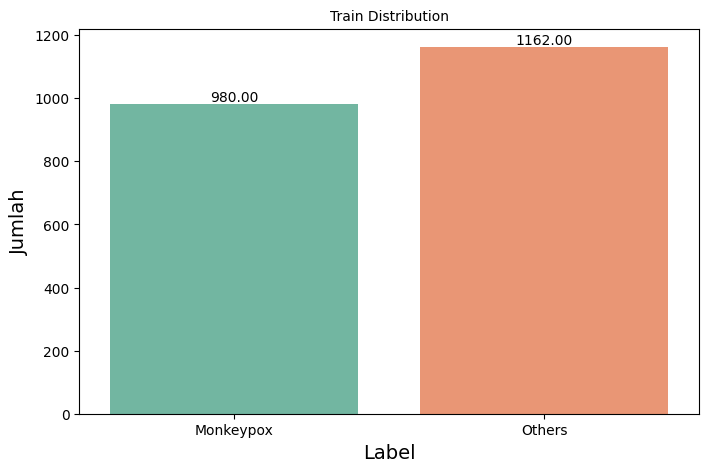

In [21]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

Pada data train terdapat 980 data Monkeypox dan 1162 data Others. Jumlah data pada kategori Others lebih banyak dibanding kategori Monkeypox.

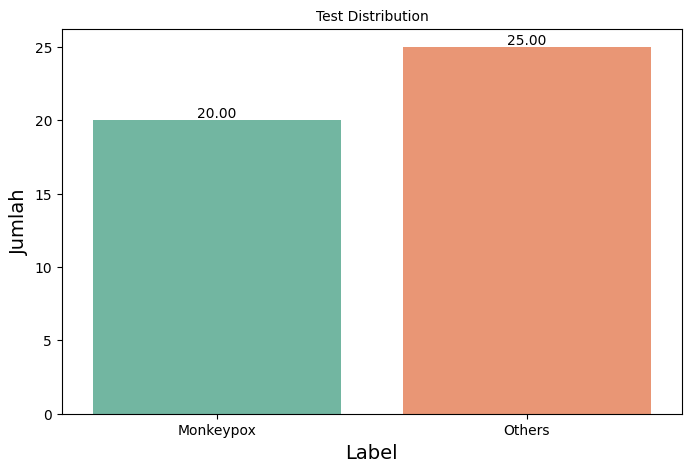

In [22]:
visualize_data(test_df, 'Test')

Pada data test terdapat 23 data Monkeypox dan 25 data Others. Jumlah data pada kategori Others lebih banyak dibanding kategori Monkeypox.

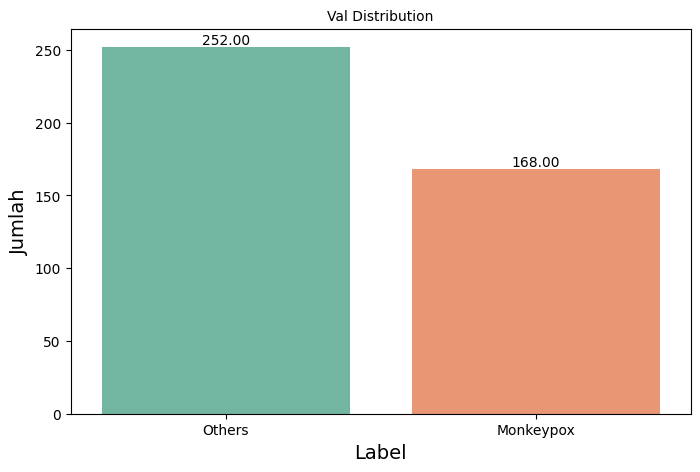

In [23]:
visualize_data(val_df, 'Val')

Pada data validation terdapat 168 data Monkeypox dan 252 data Others. Jumlah data pada kategori Others lebih banyak dibanding kategori Monkeypox.

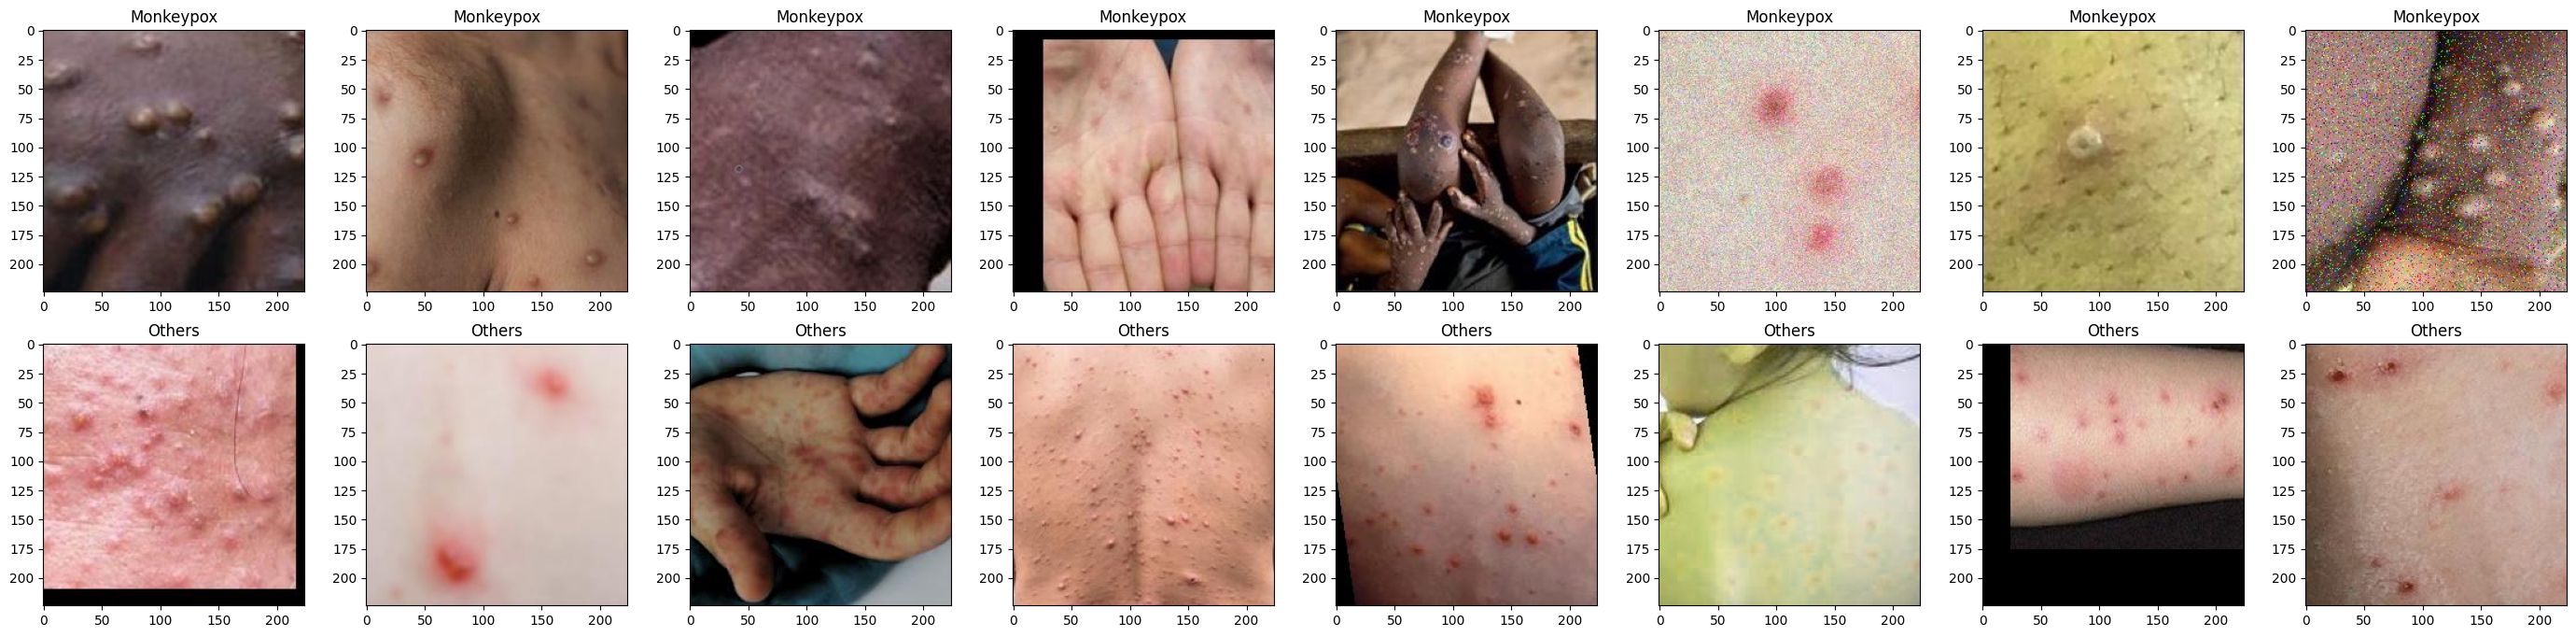

In [24]:
# Get few samples for both the classes
monkeypox_samples = (train_df[train_df['label']=='Monkeypox']['images'].iloc[:8]).tolist()
others_samples = (train_df[train_df['label']=='Others']['images'].iloc[:8]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(35,8))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//8, i%8].set_title(sample.split('/')[-2])
        ax[i//8, i%8].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(monkeypox_samples + others_samples)

Dapat dilihat dari beberapa gambar di atas bahwa gambar sudah melakukan proses data augmentasi sebelumnya. Kemudian akan di cek berapa ukuran setiap gambar.

Mencari Tahu Ukuran Gambar

In [25]:
# Membuat fungsi untuk mendapatkan ukuran dari setiap gambar
def size(name):
    width = []
    height = []
    for i in name:
        p = Image.open(i)
        print(p)

In [26]:
# Menampilkan Informasi gambar
size(train_Monkeypox)
size(train_Others)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DEA5D2F50>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE8292C80>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE82924D0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE82911E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE8292B60>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE82928C0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE8291FF0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE8292590>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE8292710>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE82928F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE82929E0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x784DE8292890>
<PIL.JpegImagePl

Dapat dilihat dari informasi di atas bahwa size gambar yaitu 224 x 224.

## 3.3 Augmentation

Pada EDA di atas diketahui bahwa gambar telah dilakukan proses Augmentasi sebelumnya. Sebenarnya peneliti tidak perlu melakukan augmentasi lagi, hanya saja kali ini peneliti akan tetap menambahkan parameter zoom dan horizontal flip dengan alasan agar model memiliki data yang bervariasi sehingga nantinya model akan belajar lebih dalam lagi. Peneliti juga melakukan rescale untuk mengubah pixel value menjadi range 0-1.

Dikarenakan data ini memiliki target binary, maka pada parameter class_mode akan diisi dengan 'binary'

In [27]:
# create image generator
train_datagen = ImageDataGenerator(rescale=1./255, #normalisasi pixel
                                   zoom_range=0.2,
                                   horizontal_flip=True)
vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
# dari dataframe bukan directory
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(224, 224), #ini buat nentuin target biar sama sizenya
    class_mode='binary',
    batch_size=64,
    shuffle=False)

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=64,
    shuffle=False)

ds_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=64,
    shuffle=False)

Found 2142 validated image filenames belonging to 2 classes.
Found 420 validated image filenames belonging to 2 classes.
Found 45 validated image filenames belonging to 2 classes.


In [29]:
# Menampilkan kelas untuk train, test, dan validation
print(ds_train.class_indices)
print(ds_val.class_indices)
print(ds_test.class_indices)

{'Monkeypox': 0, 'Others': 1}
{'Monkeypox': 0, 'Others': 1}
{'Monkeypox': 0, 'Others': 1}


Dari informasi di atas diketahui bahwa:

- Terdapat 2142 images yang termasuk kedalam 2 classes.

- Terdapat 420 images yang termasuk kedalam 2 classes.

- Terdapat 48 images yang termasuk kedalam 2 classes.

Adapun Clasess tersebut adalah : 'Monkeypox' yang diidentifikasi menjadi 0, dan 'Others' yang diidentifikasi menjadi 1.

## 3.4 Gambar Setelah Dilakukan Augmentasi

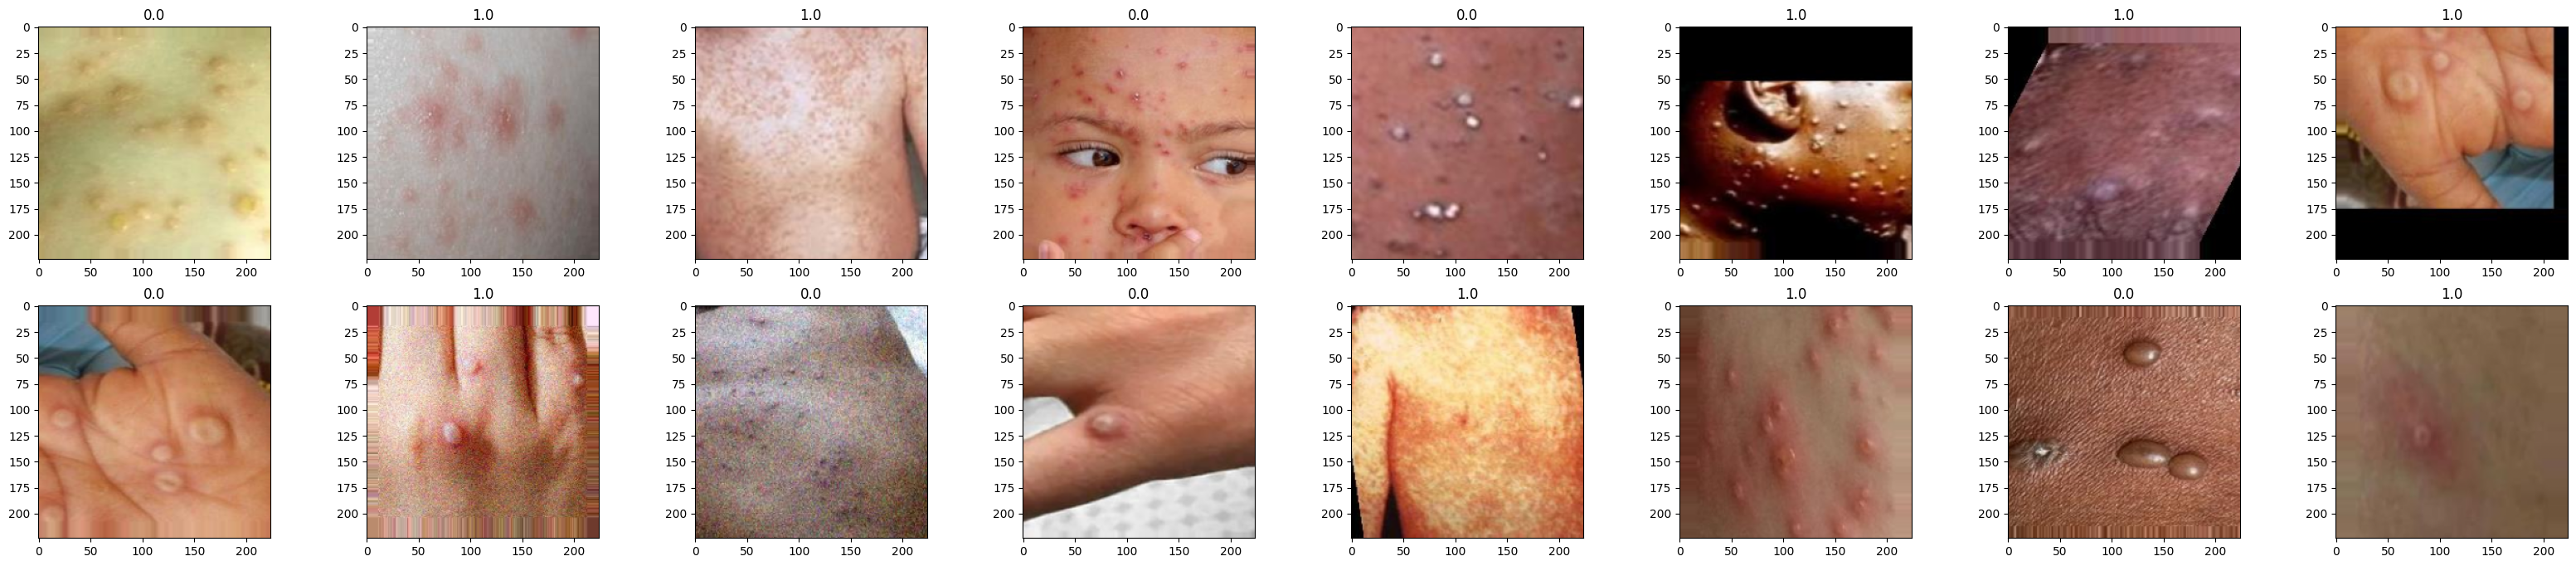

In [30]:
fig,ax = plt.subplots(nrows=2,ncols=8,figsize=(40,8))
n = 0
idx = np.random.randint(len(ds_train.next()[0]), size=16)
for i in range(2):
  for j in range(8):
    img = ds_train.next()[0][idx[n]]
    ax[i][j].imshow(img)
    ax[i][j].set_title(ds_train.next()[1][idx[n]])
    n+=1

# 4. MODEL SEQUENTIAL


Tahap ini akan dilakukan dua kali pemodelan. Untuk model pertama yaitu Sequential API dan model ke-2 yaitu transfer learning EfficientNetB0. Dipilih model transfer learning efficientNetB0 karena ukurannya yang tidak terlalu besar dan EfficientNetB0 telah terbukti mampu menggeneralisasi pengetahuannya ke tugas-tugas yang berbeda, termasuk pada dataset yang relatif kecil.

## 4.1 Model Definition

In [31]:
# Define the input shape
inputs= [224,224,3]

# Arsitektur model sequential
model= Sequential()

# Layer Conv 1
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=inputs))
model.add(MaxPooling2D(pool_size= 2, strides=2))

# Layer Conv 2
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size= 2, strides=2))

# Layer Conv 3
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size= 2, strides=2))

# model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Dropout(0.5))

# Flatten output
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))

# Output layer
model.add(Dense(units=1,activation='sigmoid'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

Berikut adalah penjelasan untuk model sequential diatas:

1. **Input Shape**: Model ini menerima input gambar dengan resolusi 224x224 piksel dan 3 saluran warna (RGB).

2. **Convolutional Layer 1**: Menggunakan 32 filter dengan ukuran kernel 3x3 dan aktivasi ReLU. Output dari lapisan ini memiliki bentuk 222x222x32. Ini karena kernel 3x3 mengurangi setiap dimensi spasial sebesar 1 piksel di setiap sisi.

3. **Max Pooling Layer 1**: Memiliki pool size 2x2 dan strides 2. Hal ini mengurangi ukuran spasial output menjadi separuhnya, menjadi 111x111x32.

4. **Convolutional Layer 2**: Memiliki 64 filter dengan ukuran kernel 3x3 dan aktivasi ReLU. Output menjadi 109x109x64, sekali lagi mengurangi setiap dimensi spasial sebesar 1 piksel di setiap sisi.

5. **Max Pooling Layer 2**: Dengan pool size 2x2 dan strides 2, output dikurangi menjadi 54x54x64.

6. **Convolutional Layer 3**: Terdiri dari 128 filter dengan kernel 3x3 dan aktivasi ReLU. Outputnya adalah 52x52x128.

7. **Max Pooling Layer 3**: Mengurangi output menjadi 26x26x128.

8. **Flatten Layer**: Meratakan output menjadi vektor satu dimensi dengan ukuran 86,528.

9. **Dense Layer 1**: Lapisan padat dengan 256 unit dan aktivasi ReLU. Output dari lapisan ini adalah vektor 256 elemen.

10. **Output Dense Layer**: Lapisan padat akhir dengan 1 unit dan aktivasi sigmoid, menghasilkan output tunggal yang mewakili prediksi klasifikasi biner.

Model ini menggabungkan lapisan konvolusional untuk ekstraksi fitur dengan lapisan padat untuk klasifikasi, cocok untuk tugas-tugas seperti pengenalan gambar.

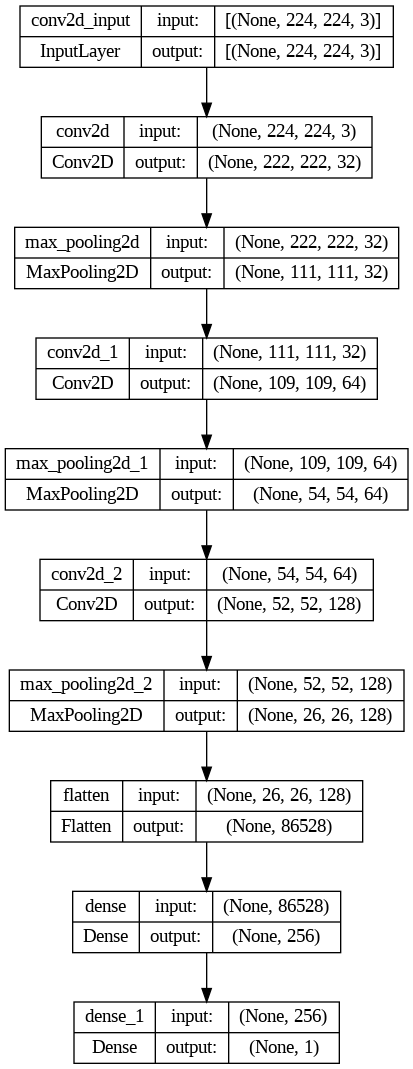

In [33]:
# Menampilkan gambar model arsitektur
tf.keras.utils.plot_model(model, show_shapes=True)

## 4.2 Model Training

In [34]:
# Membuat callbacks
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience= 3),
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
]

Callback adalah seperangkat aksi yang dilakukan pada tahapan tertentu selama pelatihan model.

1. **EarlyStopping**:
   - **monitor='val_loss'**: Callback ini memantau nilai 'val_loss', yaitu loss pada data validasi.
   - **patience=3**: Ini menentukan bahwa pelatihan akan berhenti jika 'val_loss' tidak membaik setelah 3 epoch. "Tidak membaik" berarti nilai 'val_loss' tidak menurun.
   - **restore_best_weights=True**: Setelah pelatihan dihentikan, model akan mengembalikan bobot terbaik yang dicapai selama pelatihan (berdasarkan nilai 'val_loss' terendah).

2. **ModelCheckpoint**:
   - **'model_check.h5'**: Callback ini menyimpan model ke file bernama 'model_best.hdf5'. Format H5 adalah format standar untuk menyimpan model Keras.
   - **save_best_only=True**: Model hanya akan disimpan jika versi yang disimpan adalah peningkatan (berdasarkan 'val_loss'). Ini berarti hanya model dengan 'val_loss' terendah yang akan disimpan, bukan model dari setiap epoch.

Callback digunakan untuk menghindari overfitting dan menyimpan versi model terbaik yang berdasarkan performa pada data validasi. Callbacks menghentikan pelatihan secara otomatis pada waktu yang tepat dan mengakses kembali model terbaik yang telah dilatih.

In [35]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(clipvalue=1.5)

# Compile
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = tf.keras.metrics.Precision())

In [38]:
# Train the model
history = model.fit(ds_train, batch_size= 64, epochs= 25, validation_data= ds_val, callbacks= callbacks1)

Epoch 1/25
34/34 [==============================] - 29s 863ms/step - loss: 0.5420 - precision: 0.6943 - val_loss: 0.6122 - val_precision: 0.6845
Epoch 2/25
34/34 [==============================] - 36s 1s/step - loss: 0.4991 - precision: 0.7107 - val_loss: 0.6856 - val_precision: 0.6504
Epoch 3/25
34/34 [==============================] - 44s 1s/step - loss: 0.4813 - precision: 0.7370 - val_loss: 0.5928 - val_precision: 0.6834
Epoch 4/25
34/34 [==============================] - 29s 843ms/step - loss: 0.4978 - precision: 0.7141 - val_loss: 0.7066 - val_precision: 0.6766
Epoch 5/25
34/34 [==============================] - 29s 868ms/step - loss: 0.4435 - precision: 0.7578 - val_loss: 0.6351 - val_precision: 0.6850
Epoch 6/25
34/34 [==============================] - 29s 849ms/step - loss: 0.4418 - precision: 0.7663 - val_loss: 0.8227 - val_precision: 0.7841


## 4.3 Model Evaluation

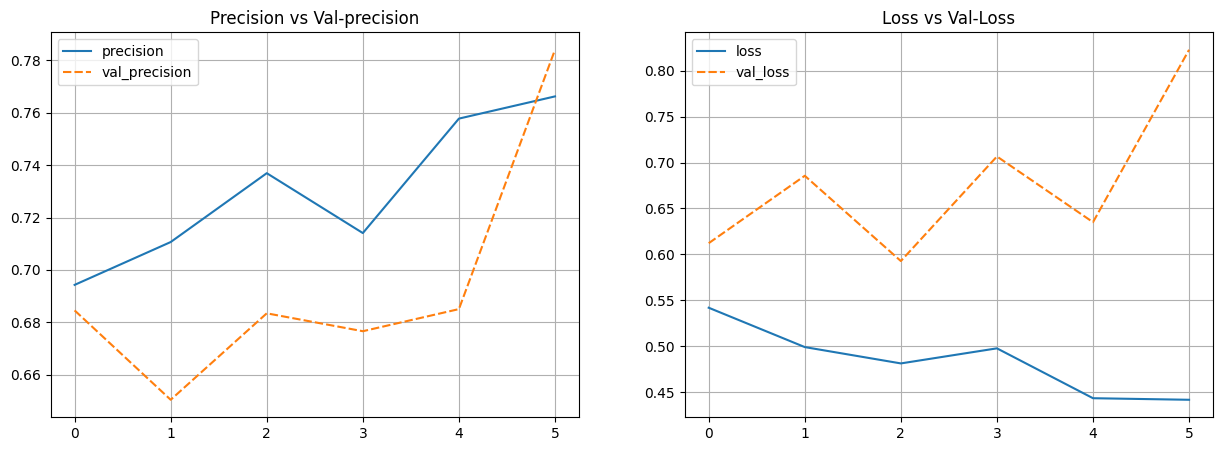

In [42]:
# Plot Training Results

history_1 = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_1[['precision', 'val_precision']])
plt.grid()
plt.title('Precision vs Val-precision')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_1[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

In [75]:
test_results = model.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]}')
print(f'Test Precision : {test_results[1]}')

Test Loss     : 0.7371510863304138
Test Precision : 0.6470588445663452


It can be seen that out model is overfit during the training. To improve this model, in the next scenarios we will add Dropout layer and Transfer Learning.

For the second scenario, we will add Dropout Layer to reduce overfitting.

In [44]:
# Memprediksi menggunakan model sequential
y_pred_test = model.predict(ds_test)

# Mengonversi probabilitas ke label kelas
y_pred_test = (y_pred_test > 0.6).astype(int)

# Classification Report dan Confusion Matrix untuk Model Sequential
announce = classification_report(ds_test.labels,
                                        y_pred_test, labels=np.arange(2),
                                        target_names=list(ds_test.class_indices.keys()))
print(announce)

1/1 [==============================] - 1s 955ms/step
              precision    recall  f1-score   support

   Monkeypox       0.46      0.80      0.58        20
      Others       0.60      0.24      0.34        25

    accuracy                           0.49        45
   macro avg       0.53      0.52      0.46        45
weighted avg       0.54      0.49      0.45        45



berdasarkan hasil clasification report di atas, berikut penjelasannya:

1. **Monkeypox**: Nilai presisi 0.46, recall 0.80, dan F1-score 0.58 untuk kelas “Monkeypox”. Ini berarti bahwa model tidak cukup baik dalam mengidentifikasi gambar “Monkeypox”.
2. **Others**: Nilai presisi 0.60, recall 0.24, dan F1-score 0.34 untuk kelas Others. Ini berarti bahwa model buruk dalam mengidentifikasi gambar “Others”.

Secara keseluruhan, model sequential ini  buruk dalam mengklasifikasikan gambar ke dalam kelas Monkeypox dan Others dengan akurasi sekitar 49%

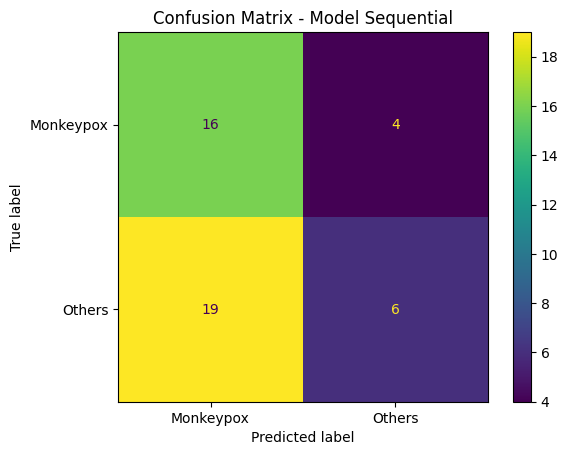

In [45]:
conf_matrix = confusion_matrix(ds_test.labels, y_pred_test)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=list(ds_test.class_indices.keys()))
disp.plot(values_format='d')
plt.title('Confusion Matrix - Model Sequential')
plt.show()

# 5. MODEL TRANSFER LEARNING EFFICIENTNETB0

## 5.1 Model Definition

In [47]:
train_datagen_netB0= ImageDataGenerator(horizontal_flip=True, zoom_range = [0.3, 1.5])
test_datagen_netB0 = ImageDataGenerator(zoom_range = [0.3, 1.5])
val_datagen_netB0 = ImageDataGenerator(zoom_range = [0.3, 1.5])

train_gen_1 = train_datagen_netB0.flow_from_directory(
    directory = '/content/images/Fold1/Fold1/Fold1/Train',
    target_size=(224,224),
    class_mode='binary',
    subset='training',
    shuffle=False
)
test_gen_1 = test_datagen_netB0.flow_from_directory(
    directory = '/content/images/Fold1/Fold1/Fold1/Test',
    target_size=(224,224),
    class_mode='binary',
    shuffle=False
)
val_gen_1 = train_datagen_netB0.flow_from_directory(
    directory = '/content/images/Fold1/Fold1/Fold1/Val',
    target_size=(224,224),
    class_mode='binary',
    shuffle=False
)

Found 2142 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Found 420 images belonging to 2 classes.


In [48]:
# Download the EfficientNet Model
effNetB0_model= EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the Lower Layer
effNetB0_model.trainable= False

train_new = tf.keras.applications.efficientnet.preprocess_input(train_gen_1)
val_new = tf.keras.applications.efficientnet.preprocess_input(val_gen_1)
test_new = tf.keras.applications.efficientnet.preprocess_input(test_gen_1)

16705208/16705208 [==============================] - 0s 0us/step


In [49]:
seed=32
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Tambahkan lapisan-lapisan yang Anda definisikan sebelumnya setelah VGG16
model_1 = Sequential()
model_1.add(effNetB0_model)

## flatten output and feed it into dense layer
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_1.add(Dropout(0.1, seed=seed))
model_1.add(tf.keras.layers.Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_1.add(Dropout(0.1, seed=seed))
model_1.add(tf.keras.layers.Dense(64, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_1.add(Dropout(0.1, seed=seed))
model_1.add(tf.keras.layers.Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_1.add(Dropout(0.1, seed=seed))

## output layer
model_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [50]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

Berikut penjelasannya model EfficentNetB0 di atas:

1. **Flatten**: Lapisan ini mengubah output 3D dari EfficientNetB0 menjadi vektor 1D agar bisa diproses oleh lapisan dense.

2. **Dense**:
   - Lapisan dense pertama dengan 512 neuron, menggunakan fungsi aktivasi ReLU.
   - Output shape: Setiap sampel dalam batch direpresentasikan oleh vektor 512 elemen.
   - Inisialisasi HeNormal digunakan untuk inisialisasi bobot, yang efektif untuk lapisan dengan aktivasi ReLU.

3. **Dropout (0.1)**: Mengurangi overfitting dengan 'menonaktifkan' secara acak 10% dari neuron pada lapisan sebelumnya selama proses pelatihan.

4. **Dense dan Dropout**: Proses yang sama seperti langkah 3 dan 4 diulangi untuk membuat lapisan dense dengan 128, 64, dan 32 neuron, masing-masing diikuti oleh lapisan dropout. Hal ini bertujuan untuk meningkatkan kapasitas model dan mengurangi overfitting.

5. **Dense (Output Layer)**: Lapisan output dengan 1 neuron, menggunakan fungsi aktivasi sigmoid Output nya yaitu probabilitas antara 0 dan 1, yang menunjukkan kelas yang diprediksi.

6. **Total Parameter**: Model memiliki total 36,238,756 parameter, di mana 32,189,185 parameter dapat dilatih, sedangkan sisanya adalah parameter yang tidak dapat dilatih dari lapisan EfficientNetB0.

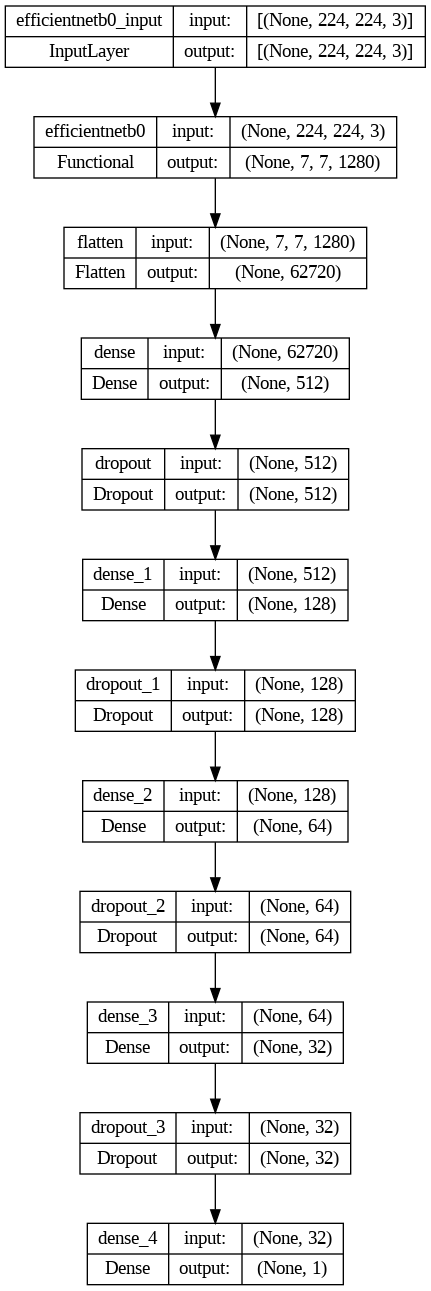

In [51]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

## 5.2 Model Training

In [52]:
# Membuat callbacks
callbacks2= [
    EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True),
    ModelCheckpoint('model_best_1.hdf5', monitor='val_loss', save_best_only=True)
]

Callback adalah seperangkat aksi yang dilakukan pada tahapan tertentu selama pelatihan model.

1. **EarlyStopping**:
   - **monitor='val_loss'**: Callback ini memantau nilai 'val_loss', yaitu loss pada data validasi.
   - **patience=3**: Ini menentukan bahwa pelatihan akan berhenti jika 'val_loss' tidak membaik setelah 3 epoch. "Tidak membaik" berarti nilai 'val_loss' tidak menurun.
   - **restore_best_weights=True**: Setelah pelatihan dihentikan, model akan mengembalikan bobot terbaik yang dicapai selama pelatihan (berdasarkan nilai 'val_loss' terendah).

2. **ModelCheckpoint**:
   - **'model_check.h5'**: Callback ini menyimpan model ke file bernama 'model_best_1.hdf5'. Format H5 adalah format standar untuk menyimpan model Keras.
   - **save_best_only=True**: Model hanya akan disimpan jika versi yang disimpan adalah peningkatan (berdasarkan 'val_loss'). Ini berarti hanya model dengan 'val_loss' terendah yang akan disimpan, bukan model dari setiap epoch.

Callback digunakan untuk menghindari overfitting dan menyimpan versi model terbaik yang berdasarkan performa pada data validasi. Callbacks menghentikan pelatihan secara otomatis pada waktu yang tepat dan mengakses kembali model terbaik yang telah dilatih.

In [53]:
# Compile
model_1.compile(loss='binary_crossentropy', optimizer='adaMax', metrics=tf.keras.metrics.Precision())

In [54]:
# Train the model
history_model_1 = model_1.fit(train_gen_1,
                              epochs=25,
                              validation_data=val_gen_1,
                              verbose=1,
                              callbacks= callbacks2)

Epoch 1/25
67/67 [==============================] - 55s 630ms/step - loss: 1.9320 - precision: 0.5769 - val_loss: 0.6873 - val_precision: 0.6712
Epoch 2/25
67/67 [==============================] - 34s 514ms/step - loss: 0.7879 - precision: 0.6530 - val_loss: 0.5988 - val_precision: 0.7665
Epoch 3/25
67/67 [==============================] - 36s 536ms/step - loss: 0.6666 - precision: 0.7035 - val_loss: 0.5437 - val_precision: 0.7189
Epoch 4/25
67/67 [==============================] - 33s 490ms/step - loss: 0.5905 - precision: 0.7118 - val_loss: 0.6146 - val_precision: 0.7340
Epoch 5/25
67/67 [==============================] - 33s 487ms/step - loss: 0.5510 - precision: 0.7433 - val_loss: 0.6664 - val_precision: 0.7351
Epoch 6/25
67/67 [==============================] - 33s 500ms/step - loss: 0.5327 - precision: 0.7660 - val_loss: 0.5710 - val_precision: 0.7398


## 5.3 Model Evaluation

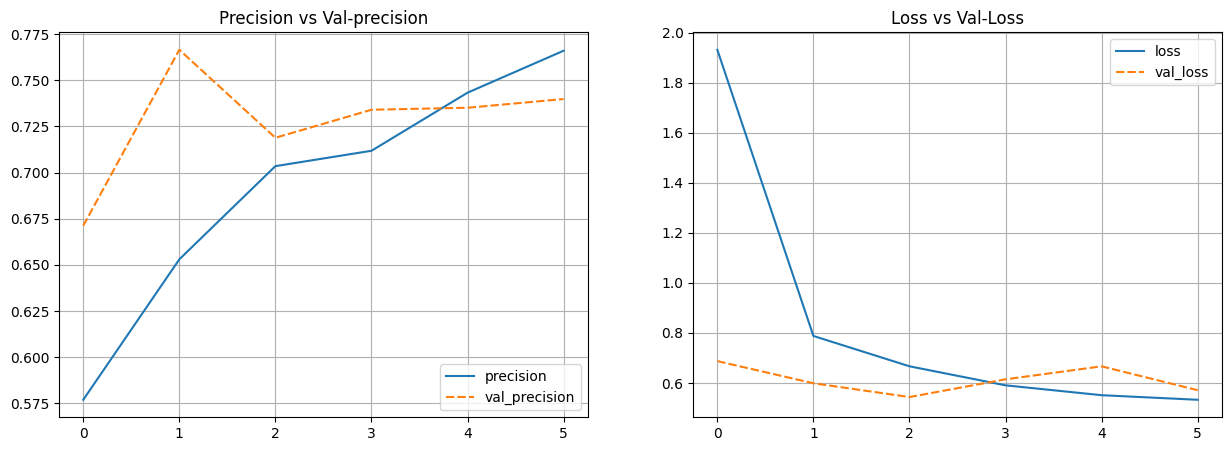

In [55]:
# Plot Training Results

history_model_1 = pd.DataFrame(history_model_1.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_1[['precision', 'val_precision']])
plt.grid()
plt.title('Precision vs Val-precision')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_1[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

In [76]:
test_results = model_1.evaluate(test_gen_1, verbose=0)
print(f'Test Loss     : {test_results[0]}')
print(f'Test Precision : {test_results[1]}')

Test Loss     : 0.3680514991283417
Test Precision : 0.9130434989929199


Dapat dilihat bahwa hasil prediksi pada data test yaitu loss sebesar 0.3680514991283417 dan precision score sebesar 0.9130434989929199. Ini merupakan angka yang cukup bagus.

In [80]:
# Memprediksi menggunakan Model EfficientNetV2B0
y_pred_test_eff = model_1.predict(test_gen_1)

# Mengonversi probabilitas ke label kelas
y_pred_test_eff = (y_pred_test_eff > 0.6).astype(int)

# Classification Report dan Confusion Matrix untuk Model EfficientNetV2B0
announce_1 = classification_report(test_gen_1.labels,
                                        y_pred_test_eff, labels=np.arange(2),
                                        target_names=list(test_gen_1.class_indices.keys()))
print(announce_1)

2/2 [==============================] - 3s 264ms/step
              precision    recall  f1-score   support

   Monkeypox       0.83      0.95      0.88        20
      Others       0.95      0.84      0.89        25

    accuracy                           0.89        45
   macro avg       0.89      0.90      0.89        45
weighted avg       0.90      0.89      0.89        45



berdasarkan hasil clasification report di atas, berikut penjelasannya:

1. **Monkeypox**: Nilai presisi 0.83, recall 0.95, dan F1-score 0.88 untuk kelas “Monkeypox”. Ini berarti bahwa model tidak cukup baik dalam mengidentifikasi gambar “Monkeypox”.
2. **Others**: Nilai presisi 0.95, recall 0.84, dan F1-score 0.89 untuk kelas Others. Ini berarti bahwa model buruk dalam mengidentifikasi gambar “Others”.

Secara keseluruhan, model EfficientNetB0 ini cukup baik dalam mengklasifikasikan gambar ke dalam kelas Monkeypox dan Others dengan akurasi sekitar 89%. Model ini merupakan model terbaik dibanding model lainnya yang di uji.

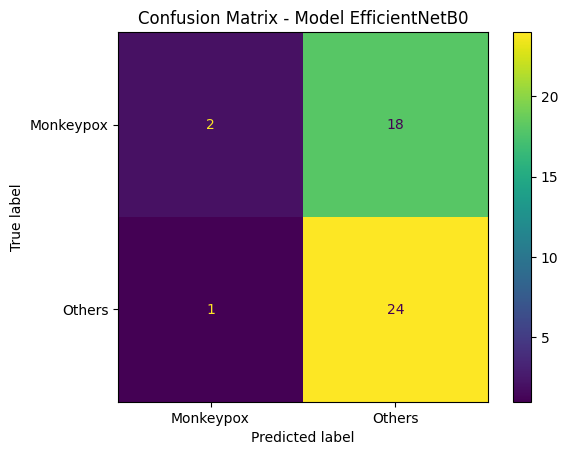

In [58]:
conf_matrix_eff = confusion_matrix(test_gen_1.labels, y_pred_test_eff)
disp_eff = ConfusionMatrixDisplay(conf_matrix_eff, display_labels=list(test_gen_1.class_indices.keys()))
disp_eff.plot(values_format='d')
plt.title('Confusion Matrix - Model EfficientNetB0')
plt.show()

# 6. MODEL FUNCTIONAL

## 6.1 Model Definition

In [66]:
tf.keras.backend.clear_session()
tf.random.set_seed(20)

# Definisi Input layer
input_shape_img = Input(shape=(224, 224, 3))

# Convolutional layer
conv = Conv2D(32, (3, 3), activation='relu')(input_shape_img)

# MaxPooling layer
maxpool = MaxPooling2D((2, 2))(conv)

# Flatten layer
flatten = Flatten()(maxpool)

# Dense layer (fully connected)
dense1 = Dense(64, activation='relu')(flatten)

# Output layer
output = Dense(1, activation='sigmoid')(dense1)

# Membuat model fungsional
model_2 = tf.keras.Model(inputs=input_shape_img, outputs=output)

In [67]:
# Menampilkan ringkasan arsitektur model
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 64)                25233472  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

Berikut adalah penjelasan dari model functional:

1. **Input Layer**: Menerima input gambar dan ukuran input adalah 224x224 piksel dengan 3 saluran warna (RGB).

2. **Convolutional Layer**: Melakukan operasi konvolusi untuk mengekstrak fitur dari gambar. Dan output shape menandakan ukuran output setelah konvolusi dengan 32 filter.

3. **MaxPooling Layer**: Mengurangi dimensi spasial dari output konvolusi untuk mengurangi jumlah parameter dan komputasi.

4. **Flatten Layer**: Mengubah output berbentuk matriks menjadi vektor satu dimensi atau meratakan output menjadi vektor.

5. **Dense Layer**: Lapisan padat (fully connected) untuk pengambilan keputusan berdasarkan fitur yang telah diekstraksi. Pada output shape mengindikasikan ada 64 unit/neuron.

6. **Output Layer**: Lapisan output untuk klasifikasi biner (misalnya, ya/tidak).

**Total Parameter**: 25,234,433, dengan semua parameter dapat dilatih. Ukuran total model adalah sekitar 96.26 MB.

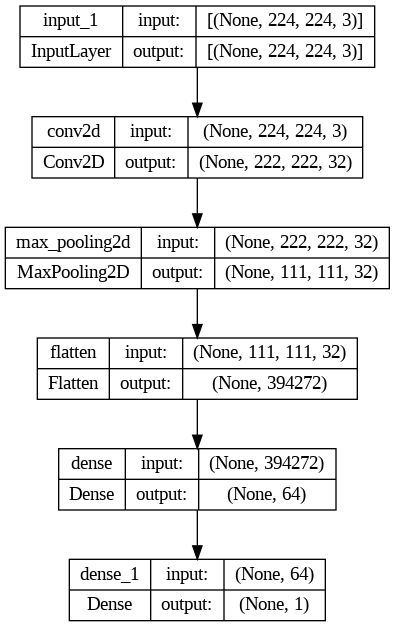

In [68]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

## 6.2 Model Training

In [63]:
# Membuat callbacks
callbacks3= [
    EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True),
    ModelCheckpoint('model_best_2.hdf5', monitor='val_loss', save_best_only=True)
]

Callback adalah seperangkat aksi yang dilakukan pada tahapan tertentu selama pelatihan model.

1. **EarlyStopping**:
   - **monitor='val_loss'**: Callback ini memantau nilai 'val_loss', yaitu loss pada data validasi.
   - **patience=3**: Ini menentukan bahwa pelatihan akan berhenti jika 'val_loss' tidak membaik setelah 3 epoch. "Tidak membaik" berarti nilai 'val_loss' tidak menurun.
   - **restore_best_weights=True**: Setelah pelatihan dihentikan, model akan mengembalikan bobot terbaik yang dicapai selama pelatihan (berdasarkan nilai 'val_loss' terendah).

2. **ModelCheckpoint**:
   - **'model_check.h5'**: Callback ini menyimpan model ke file bernama 'model_best_2.hdf5'. Format H5 adalah format standar untuk menyimpan model Keras.
   - **save_best_only=True**: Model hanya akan disimpan jika versi yang disimpan adalah peningkatan (berdasarkan 'val_loss'). Ini berarti hanya model dengan 'val_loss' terendah yang akan disimpan, bukan model dari setiap epoch.

Callback digunakan untuk menghindari overfitting dan menyimpan versi model terbaik yang berdasarkan performa pada data validasi. Callbacks menghentikan pelatihan secara otomatis pada waktu yang tepat dan mengakses kembali model terbaik yang telah dilatih.

In [70]:
# Compile
model_2.compile(loss='binary_crossentropy', optimizer='adaMax', metrics=tf.keras.metrics.Precision())

In [71]:
# Train the model
history_model_2 = model_2.fit(ds_train,
                              epochs=25,
                              validation_data=ds_val,
                              verbose=1,
                              callbacks= callbacks3)

Epoch 1/25
34/34 [==============================] - 31s 866ms/step - loss: 3.7058 - precision: 0.5704 - val_loss: 1.4199 - val_precision: 0.6492
Epoch 2/25
34/34 [==============================] - 29s 851ms/step - loss: 0.7403 - precision: 0.6333 - val_loss: 0.6854 - val_precision: 0.6616
Epoch 3/25
34/34 [==============================] - 39s 1s/step - loss: 0.6067 - precision: 0.6516 - val_loss: 0.6270 - val_precision: 0.6716
Epoch 4/25
34/34 [==============================] - 36s 1s/step - loss: 0.5931 - precision: 0.6726 - val_loss: 0.7185 - val_precision: 0.6225
Epoch 5/25
34/34 [==============================] - 33s 973ms/step - loss: 0.5834 - precision: 0.6797 - val_loss: 0.5943 - val_precision: 0.6781
Epoch 6/25
34/34 [==============================] - 31s 922ms/step - loss: 0.5607 - precision: 0.6948 - val_loss: 0.5887 - val_precision: 0.7031
Epoch 7/25
34/34 [==============================] - 28s 827ms/step - loss: 0.5296 - precision: 0.7111 - val_loss: 0.6784 - val_precision

## 6.3 Model Evaluation

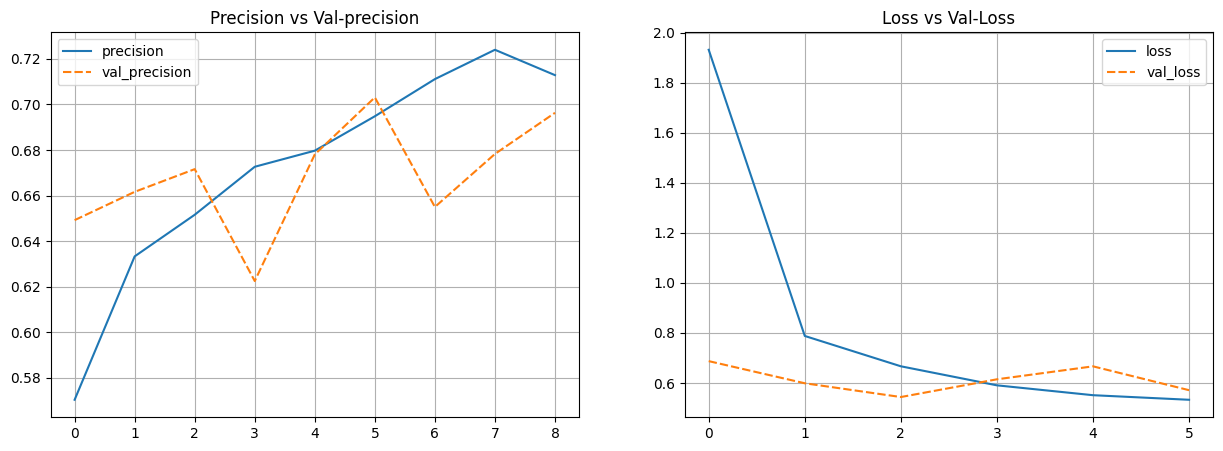

In [72]:
# Plot Training Results

history_model_2 = pd.DataFrame(history_model_2.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_model_2[['precision', 'val_precision']])
plt.grid()
plt.title('Precision vs Val-precision')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_model_1[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.show()

In [77]:
test_results = model_2.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]}')
print(f'Test Precision : {test_results[1]}')

Test Loss     : 0.7253862023353577
Test Precision : 0.695652186870575


In [79]:
# Memprediksi menggunakan model sequential
y_pred_test_1 = model_2.predict(ds_test)

# Mengonversi probabilitas ke label kelas
y_pred_test = (y_pred_test > 0.6).astype(int)

# Classification Report dan Confusion Matrix untuk Model Sequential
announce = classification_report(ds_test.labels,
                                        y_pred_test, labels=np.arange(2),
                                        target_names=list(ds_test.class_indices.keys()))
print(announce)

1/1 [==============================] - 0s 199ms/step
              precision    recall  f1-score   support

   Monkeypox       0.46      0.80      0.58        20
      Others       0.60      0.24      0.34        25

    accuracy                           0.49        45
   macro avg       0.53      0.52      0.46        45
weighted avg       0.54      0.49      0.45        45



berdasarkan hasil clasification report di atas, berikut penjelasannya:

1. **Monkeypox**: Nilai presisi 0.46, recall 0.80, dan F1-score 0.58 untuk kelas “Monkeypox”. Ini berarti bahwa model tidak cukup baik dalam mengidentifikasi gambar “Monkeypox”.
2. **Others**: Nilai presisi 0.60, recall 0.24, dan F1-score 0.34 untuk kelas Others. Ini berarti bahwa model buruk dalam mengidentifikasi gambar “Others”.

Secara keseluruhan, model functional ini kurang baik dalam mengklasifikasikan gambar ke dalam kelas Monkeypox dan Others dengan akurasi sekitar 49%

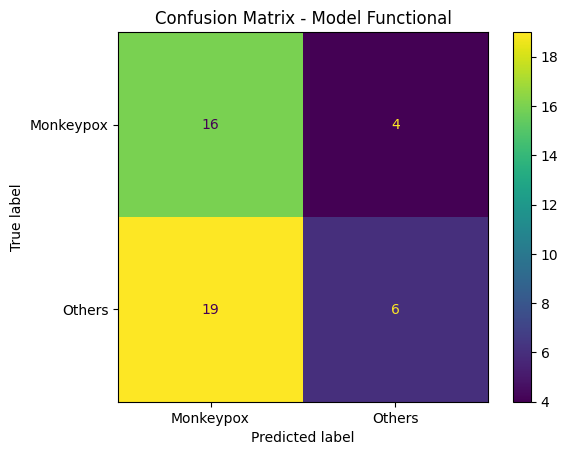

In [74]:
conf_matrix_func = confusion_matrix(ds_test.labels, y_pred_test)
disp_func = ConfusionMatrixDisplay(conf_matrix_func, display_labels=list(ds_test.class_indices.keys()))
disp_func.plot(values_format='d')
plt.title('Confusion Matrix - Model Functional')
plt.show()

# 7. MODEL SAVING

Model saving dilakukan pada model terbaik yaitu 'model_best_1.hdf5' untuk Model Transfer Learning EfficientNetB0. 

# 8. MODEL INFERENCE

ada pada file 'P2G7_inference_rian.ipynb'

# 9. KESIMPULAN

1. Model EfficientNetB0 melakukan pekerjaan yang baik dalam mengklasifikasikan gambar ke dalam kelas 'Monkeypox' dan 'Others'. Dengan nilai akurasi sekitar 89%, precision score pada Monkeypox sebesar 83%, dan precision score pada Monkeypox sebesar 95%. Model Functional terpilih menjadi model terbaik dibandingkan model sequential dan functional.

2. Metric yang dipilih adalah metric precision, metric ini dipilih karena dalam konteks ini, dengan alasan ingin meminimalkan kesalah prediksi yang seharusnya (actual) tergolong Monkepox tapi terprediksi Others. Identifikasi penyakit Monkeypox ini bertujuan agar pihak terakit dapat dengan cepat mengendalikan sehingga penularannya tidak meluas dan mutasi virus penyebab Monkey Pox bisa diminimalkan.
